## Imports

In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save the model
model_path = '/content/drive/My Drive/kyle_parks_basic_model.keras'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

## Preprocess and Splitting

In [ ]:
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [ ]:
bikes.head()

,dteday,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday
0,1/1/2011,0.0,3,13,3.0,3.0,0.7957,0.8,1,1,0,0
1,1/1/2011,1.0,8,30,1.7,1.7,0.8272,0.8,1,1,0,0
2,1/1/2011,2.0,5,26,1.9,1.9,0.8157,1.1,1,1,0,0
3,1/1/2011,3.0,3,9,2.5,2.5,0.7831,0.8,1,1,0,0
4,1/1/2011,4.0,0,1,2.0,2.0,0.8075,1.1,1,1,0,0


In [ ]:
def cycle_encode(data, col, max_val):
    # https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [ ]:
def preprocess_bike_data(df):

    # Convert 'dteday' to datetime
    df['dteday'] = pd.to_datetime(df['dteday'], format='%m/%d/%Y')

    # Ensure 'hr' is an integer
    df['hr'] = df['hr'].astype(int)

    # Combine 'dteday' and 'hr' into a single 'datetime' column
    df['dteday'] = df.apply(lambda row: pd.Timestamp(row['dteday']) + pd.Timedelta(hours=row['hr']), axis=1)

    # Create year, month, and day columns
    df['year']        = df['dteday'].dt.year
    df['month']       = df['dteday'].dt.month
    df['day']         = df['dteday'].dt.day
    df['day_of_week'] = df['dteday'].dt.dayofweek
    df["day_of_year"] = df['dteday'].dt.dayofyear

    #Change time data to a cycle
    df = cycle_encode(df, 'hr', 24)
    df = cycle_encode(df, 'day', 31)
    df = cycle_encode(df, 'day_of_week', 7)
    df = cycle_encode(df, 'month', 12)
    df = cycle_encode(df, 'day_of_year', 365)

    startDate = '2020-03-01 00:00:00'
    endDate = '2021-04-01 00:00:00'
    df['covid'] = df.dteday.apply(lambda x: 1 if pd.to_datetime(startDate) <= x < pd.to_datetime(endDate) else 0)

    df['weathersit'] = df['weathersit'].map({1: 'Clear', 2: 'Mist', 3: 'Light Rain', 4: 'Heavy Rain'})
    df['season'] = df['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

    df.drop(['hr', 'day', 'day_of_week', 'month', 'day_of_year'], axis=1, inplace=True)

    return df


In [ ]:
bikes = preprocess_bike_data(bikes)

bikes.head()

In [ ]:
'''
This is a chronological train/ test split.
'''

# Get dummies
bikes_dum = pd.get_dummies(bikes, columns=['weathersit', 'season', 'year'])

# Ensure the data is sorted by 'datetime' to maintain chronological order
bikes_dum = bikes_dum.sort_values(by='dteday')

# Create the target variable
bikes_dum['combined_y'] = bikes_dum['casual'] + bikes_dum['registered']
y = bikes_dum['combined_y']

# Define indices for chronological splitting
split_index = int(len(bikes_dum) * 0.9)

# Split the data chronologically
# Get the size of bikes for train/validation/testing
train_size = int(0.9 * len(bikes))
val_size = int(0.05 * len(bikes))
test_size = len(bikes) - train_size - val_size

# Split the data for train/val/test
train_data = bikes_dum[:train_size]
val_data = bikes_dum[train_size:train_size + val_size]
test_data = bikes_dum[train_size + val_size:]

# Separate features and target for training and testing sets
y_train = train_data['combined_y']
y_test = test_data['combined_y']
y_val = val_data['combined_y']

X_train = train_data.drop(['combined_y', 'dteday', 'casual', 'registered'], axis=1)
X_test = test_data.drop(['combined_y', 'dteday', 'casual', 'registered'], axis=1)
X_val = val_data.drop(['combined_y', 'dteday', 'casual', 'registered'], axis=1)

# Scale the data
minmax_scaler = preprocessing.MinMaxScaler()
X_train = minmax_scaler.fit_transform(X_train)
X_test = minmax_scaler.transform(X_test)
X_val = minmax_scaler.transform(X_val)

#TODO minmax scaler wasn't run on x_val?

# Display the shapes of the datasets to verify
print(f'Training data shape: {X_train.shape}, Training target shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing target shape: {y_test.shape}')
print(f'Validation data shape: {X_val.shape}, Validation target shape: {y_val.shape}')

Training data shape: (101227, 38), Training target shape: (101227,)
Testing data shape: (5625, 38), Testing target shape: (5625,)
Validation data shape: (5623, 38), Validation target shape: (5623,)


In [ ]:
#train_data.head()

,dteday,casual,registered,temp_c,feels_like_c,hum,windspeed,holiday,workingday,hr_sin,...,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,combined_y
0,2011-01-01 00:00:00,3,13,3.0,3.0,0.7957,0.8,0,0,0.000000,...,False,False,False,False,False,False,False,False,False,16
1,2011-01-01 01:00:00,8,30,1.7,1.7,0.8272,0.8,0,0,0.258819,...,False,False,False,False,False,False,False,False,False,38
2,2011-01-01 02:00:00,5,26,1.9,1.9,0.8157,1.1,0,0,0.500000,...,False,False,False,False,False,False,False,False,False,31
3,2011-01-01 03:00:00,3,9,2.5,2.5,0.7831,0.8,0,0,0.707107,...,False,False,False,False,False,False,False,False,False,12
4,2011-01-01 04:00:00,0,1,2.0,2.0,0.8075,1.1,0,0,0.866025,...,False,False,False,False,False,False,False,False,False,1


In [ ]:
#train_data.columns

Index(['dteday', 'casual', 'registered', 'temp_c', 'feels_like_c', 'hum',
       'windspeed', 'holiday', 'workingday', 'hr_sin', 'hr_cos', 'day_sin',
       'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'covid',
       'weathersit_Clear', 'weathersit_Heavy Rain', 'weathersit_Light Rain',
       'weathersit_Mist', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'year_2023', 'combined_y'],
      dtype='object')

In [ ]:
#X_train[:1]

array([[0.32065217, 0.36684783, 0.77576556, 0.01146132, 0.        ,
        0.        , 0.5       , 1.        , 0.60077861, 0.98973865,
        0.        , 0.35689587, 0.75      , 0.9330127 , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

## Make Model

In [ ]:
# Initialize the Neural Network
model = Sequential() # Sequential just means the network doesn't have loops--the outputs of one layer of neurons go to the next layer of neurons

# Add the first layer
# model.add(Dense(16, input_dim=38, activation='relu')) # This layer has 16 neurons. They are each connected (dense) to the input neurons.
# Note: We want the input dimension to match the number of features at our input layer

#input_dim encounters an error when loading later
# per https://stackoverflow.com/questions/69112466/why-tensorflow-throws-this-exception-when-loading-a-model-that-was-normalized-li
#Trying input_shape instead?
model.add(Dense(16, input_shape=(38,), activation='relu'))

#TOD why was that worse!?

# Add another "hidden layer"
model.add(Dense(12, activation = 'relu')) # This layer has 8 neurons
#RULE OF THUMB (2/3)input + output, or mean of input and output

# Add layer for registered and non-registered
model.add(Dense(2, activation = 'relu')) # This layer has 2 neurons
#TODO should this be linear also?

# Add the "output layer"
model.add(Dense(1, activation='linear')) # Our last layer doesn't need a non-linear activation function, unless it is useful for the type of answer we want
# The ouput layer should have the same number of neurons as outputs you are generating. In this case, it is just producing one number.
#Linear returns the input unmodified

# Compile model
model.compile(loss='MSE', optimizer= 'Adam', metrics=['mean_squared_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 500, verbose = 0)

In [ ]:
#TODO Train the model with hyperparameters
# history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 10, epochs = 250, verbose = 1)

(0.0, 50000.0)

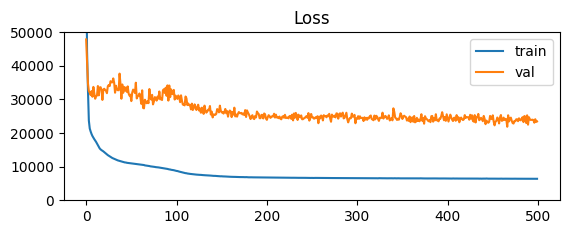

In [ ]:
# Plot loss during training (we can do this because we saved a "history" during training)

plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.ylim(0,50000)

## Save Model

In [ ]:
# Save the model
model.save(model_path)

## Hyperparameter Tuning

In [ ]:
# We can make several different models, so let's make a function to make the model

# Function to create model, required for KerasClassifier / KerasRegressor
def create_model(optimizer='adam'):
  model = Sequential()
  model.add(Dense(16, input_shape=(38,), activation='relu'))
  model.add(Dense(12, activation = 'relu'))
  model.add(Dense(2, activation = 'relu'))
  model.add(Dense(1, activation='linear'))
	# Compile model
  model.compile(loss='MSE', optimizer=optimizer, metrics=['mse'])
  return model

# Let's use the KerasRegressor tool to make the model so that we can pass it to a hyperparameter grid search
model = KerasRegressor(model=create_model, verbose=0)

# Define the grid search parameters
batch_size = range(10, 50)
epochs = range(100, 500)
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Run the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -59628.487630 using {'batch_size': 10, 'epochs': 100}
-59628.487630 (44774.160038) with: {'batch_size': 10, 'epochs': 100}
-117126.113281 (71616.784257) with: {'batch_size': 10, 'epochs': 20}
-118466.417969 (47846.356488) with: {'batch_size': 30, 'epochs': 100}
-125514.438802 (99611.047269) with: {'batch_size': 30, 'epochs': 20}


## Load Model

In [ ]:
from keras import models
loaded_model = models.load_model(model_path)

## Test Predictions

In [ ]:
def get_predict(model):
  predictions = np.round(model.predict(X_test),1)
  return predictions

def get_r(predictions, y_test):
  r2 = r2_score(y_test,predictions)
  return r2

def get_mse(predictions, y_test):
  MSE = mean_squared_error(y_test,predictions)
  return MSE

def get_rmse(predictions, y_test):
  rmse = np.sqrt(get_mse(predictions, y_test))
  return rmse

def get_mean_ae(predictions, y_test):
  return mean_absolute_error(y_test,predictions)

def get_median_ae(predictions, y_test):
  return median_absolute_error(y_test,predictions)

In [ ]:
def get_scores(predictions, y_test):
  print("R2: ", get_r(predictions, y_test))
  print("MSE: ", get_mse(predictions, y_test))
  print("RMSE: ", get_rmse(predictions, y_test))
  print("Mean Absolute: ", get_mean_ae(predictions, y_test))
  print("Median Absolute: ", get_median_ae(predictions,y_test))


In [ ]:
#The cap at 800 was a result of sigmoid

model_predictions = get_predict(loaded_model)

print("base model predictions")
get_scores(model_predictions, y_test)

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
base model predictions
R2:  -0.06644153594970703
MSE:  231191.47674912878
RMSE:  480.82374811268295
Mean Absolute:  384.56894236450194
Median Absolute:  365.3000030517578


## Hold Out Dataset

In [ ]:
# Load and preprocess mini_holdout
# mini_holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv')
mini_holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv')
mini_holdout = preprocess_bike_data(mini_holdout)

In [ ]:
#mini_holdout.head()

,dteday,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday,year,...,hr_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,covid
0,2023-11-01 00:00:00,6.0,3.8,0.6359,10.8,Clear,Winter,0,1,2023,...,1.000000,0.201299,0.97953,0.974928,-0.222521,-0.5,0.866025,0.81485,0.579671,0
1,2023-11-01 01:00:00,6.0,3.4,0.6333,12.7,Clear,Winter,0,1,2023,...,0.965926,0.201299,0.97953,0.974928,-0.222521,-0.5,0.866025,0.81485,0.579671,0
2,2023-11-01 02:00:00,5.3,2.6,0.6598,12.0,Clear,Winter,0,1,2023,...,0.866025,0.201299,0.97953,0.974928,-0.222521,-0.5,0.866025,0.81485,0.579671,0
3,2023-11-01 03:00:00,5.1,3.8,0.6636,6.3,Clear,Winter,0,1,2023,...,0.707107,0.201299,0.97953,0.974928,-0.222521,-0.5,0.866025,0.81485,0.579671,0
4,2023-11-01 04:00:00,4.0,1.8,0.7192,8.4,Clear,Winter,0,1,2023,...,0.500000,0.201299,0.97953,0.974928,-0.222521,-0.5,0.866025,0.81485,0.579671,0


In [ ]:
#mini_holdout.columns

Index(['dteday', 'temp_c', 'feels_like_c', 'hum', 'windspeed', 'weathersit',
       'season', 'holiday', 'workingday', 'year', 'hr_sin', 'hr_cos',
       'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'covid'],
      dtype='object')

In [ ]:
# Get dummies
mini_holdout_dum = pd.get_dummies(mini_holdout, columns=['weathersit', 'season', 'year'])

mini_holdout_dum = mini_holdout_dum.drop(['dteday'], axis=1)

In [ ]:
#mini_holdout_dum.head()

,temp_c,feels_like_c,hum,windspeed,holiday,workingday,hr_sin,hr_cos,day_sin,day_cos,...,day_of_year_sin,day_of_year_cos,covid,weathersit_Clear,weathersit_Heavy Rain,weathersit_Light Rain,weathersit_Mist,season_Spring,season_Winter,year_2023
0,6.0,3.8,0.6359,10.8,0,1,0.000000,1.000000,0.201299,0.97953,...,0.81485,0.579671,0,True,False,False,False,False,True,True
1,6.0,3.4,0.6333,12.7,0,1,0.258819,0.965926,0.201299,0.97953,...,0.81485,0.579671,0,True,False,False,False,False,True,True
2,5.3,2.6,0.6598,12.0,0,1,0.500000,0.866025,0.201299,0.97953,...,0.81485,0.579671,0,True,False,False,False,False,True,True
3,5.1,3.8,0.6636,6.3,0,1,0.707107,0.707107,0.201299,0.97953,...,0.81485,0.579671,0,True,False,False,False,False,True,True
4,4.0,1.8,0.7192,8.4,0,1,0.866025,0.500000,0.201299,0.97953,...,0.81485,0.579671,0,True,False,False,False,False,True,True


In [ ]:
#mini_holdout_dum.columns

Index(['temp_c', 'feels_like_c', 'hum', 'windspeed', 'holiday', 'workingday',
       'hr_sin', 'hr_cos', 'day_sin', 'day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin',
       'day_of_year_cos', 'covid', 'weathersit_Clear', 'weathersit_Heavy Rain',
       'weathersit_Light Rain', 'weathersit_Mist', 'season_Spring',
       'season_Winter', 'year_2023'],
      dtype='object')

In [ ]:
train_cols = train_data.drop(['combined_y', 'dteday', 'casual', 'registered'], axis=1).columns

mini_holdout_dum_2 = mini_holdout_dum.reindex(columns=train_cols, fill_value=0)

In [ ]:
#mini_holdout_dum_2.head()

,temp_c,feels_like_c,hum,windspeed,holiday,workingday,hr_sin,hr_cos,day_sin,day_cos,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023
0,6.0,3.8,0.6359,10.8,0,1,0.000000,1.000000,0.201299,0.97953,...,0,0,0,0,0,0,0,0,0,True
1,6.0,3.4,0.6333,12.7,0,1,0.258819,0.965926,0.201299,0.97953,...,0,0,0,0,0,0,0,0,0,True
2,5.3,2.6,0.6598,12.0,0,1,0.500000,0.866025,0.201299,0.97953,...,0,0,0,0,0,0,0,0,0,True
3,5.1,3.8,0.6636,6.3,0,1,0.707107,0.707107,0.201299,0.97953,...,0,0,0,0,0,0,0,0,0,True
4,4.0,1.8,0.7192,8.4,0,1,0.866025,0.500000,0.201299,0.97953,...,0,0,0,0,0,0,0,0,0,True


In [ ]:
#mini_holdout_dum_2.columns

Index(['temp_c', 'feels_like_c', 'hum', 'windspeed', 'holiday', 'workingday',
       'hr_sin', 'hr_cos', 'day_sin', 'day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin',
       'day_of_year_cos', 'covid', 'weathersit_Clear', 'weathersit_Heavy Rain',
       'weathersit_Light Rain', 'weathersit_Mist', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
       'year_2022', 'year_2023'],
      dtype='object')

In [ ]:
mini_holdout_dum_scaled = minmax_scaler.transform(mini_holdout_dum_2)

In [ ]:
#mini_holdout_dum_scaled[:1]

array([[0.375     , 0.37771739, 0.60037318, 0.15472779, 0.        ,
        1.        , 0.5       , 1.        , 0.60077861, 0.98973865,
        1.        , 0.35689587, 0.25      , 0.9330127 , 0.89521044,
        0.28161664, 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        ]])

In [ ]:
# Make predictions
mini_holdout_predictions = loaded_model.predict(mini_holdout_dum_scaled)

# Format and export data
predictions_table = pd.DataFrame(mini_holdout_predictions, columns=['predictions'])
predictions_table.to_csv('team5-module4-predictions.csv', index=False)
print(predictions_table.value_counts())

46/46 [==============================] - 0s 1ms/step
predictions
16.714890      215
3.702567        24
104.586739       2
349.608826       1
354.090332       1
              ... 
161.056351       1
161.032364       1
160.766708       1
160.480743       1
1251.667358      1
Name: count, Length: 1227, dtype: int64
